In [1]:
import spacy
spacy.prefer_gpu(1) #maybe us en_core_web_lg instead of trf if no gpu
import xml.etree.ElementTree as ET
from spacy.symbols import nsubj, dobj, pobj, iobj, neg, xcomp, ccomp, VERB, AUX
from gensim.parsing.preprocessing import strip_multiple_whitespaces
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch
import pandas as pd
import re
import os
import sys

def main():
    nlp = spacy.load('en_core_web_trf')
    read = read_lines(sys.argv[1])

    verb_dict, spec_dict, spec_code = verb_code_dict(sys.argv[2], sys.argv[3])

    found = []
    not_found = []
    for idx, line in enumerate(read):
        matched, not_matched = get_triples(line, verb_dict, spec_dict, spec_code, nlp)
        if len(not_matched) != 4:   #if list contains sublists (e.g. [[subj, rel, obj, sent], [[subj, rel, obj, sent], [subj, rel, obj, sent]]])
            for sublist in not_matched:
                not_found.append(sublist)
        else: not_found.append(not_matched)
        if matched != " ".join([]):
            found.append([line, matched])

        if idx % 10000 == 0: print(f"done with tagging line {idx} out of {len(read)}")
    
    df = pd.DataFrame(found, columns = ["text", "label"])
    df.to_csv(sys.argv[4])

    print("potential triplets: ", len(not_found) + len(found))
    print("identified triplets: ", len(found))
    print("missed triplets: ", len(not_found))

    #to check what verbs may need to be added
    df_fix = pd.DataFrame(not_found, columns = ["subj", "rel", "obj", "text"])
    df_fix.to_csv("unmachted_2.csv")


    print("starting entailment prediction...")
    new_df = check_entailment(df)

    new_df.to_csv(sys.argv[4])
    print("dataframe saved...")

def read_lines(inputparsed):    
    """takes input from CoreNLP sentence parsed file and returns sentences"""
    #parse all lines from CoreNLP sentence split
    parsed = open(inputparsed, encoding = "utf-8")
    parsedfile = parsed.readlines()
    parsedlines = []

    #Only keep those lines which have Sentence #n in the line before
    for idx, text in enumerate(parsedfile):
        if text.startswith("Sentence #"):
            parsedlines.append(parsedfile[idx+1].replace('\n','').strip())
    
    return parsedlines

def gen_poss(line, verb_match, pre_dict):
    """generates all possibilities of patterns that a multi word line implies,
    by extracting partial patterns and resolving placeholder words"""
    poss = []

    #replace special tokens in text that are clear at this point
    line = line.replace("*", verb_match)
    line = line.replace("- ", "")
    line = line.replace("+","")
    line = line.replace("%","")
    line = line.replace("^","")
    line = line.replace("$","")

    #split line by possibility indicators and code (always ends possibility)
    #example.: "- $ * (P ON KILLING (P OF + [010] #  COMMENT <ELH 07 May 2008>"
    poss_split = re.split("\(P |\[.*]",line) 

    if len(poss_split) > 2: #2 is if no (P in the line
        #only combining the first (P, as they share the same code 
        #and the longer version will never be contained in a text if the shorter isnt
        poss.append(strip_multiple_whitespaces(" ".join(poss_split[:2])).lower().rstrip().lstrip())
    else: 
        poss.append(strip_multiple_whitespaces(poss_split[0].lower().rstrip().lstrip()))

    cleaned = []
    for text in list(set(poss)):
        c = 0
        for tag in list(pre_dict.keys()):
            if tag in text:
                for replacement in pre_dict[tag]:
                    cleaned.append(text.replace(tag, replacement))
                    c += 1
        if c == 0:
            cleaned.append(text)

    return cleaned
    

def verb_code_dict(pico_path, verb_path):
    """reads coding ontology and verb lists, 
    directly matches verbs to their CAMEO codes and returns this verbs:codes dictionairy.
    verb with codes that cannot be read are printed out as full line of the file"""
    #read PETRARCH Internal Coding Ontology (= pico)
    pico_path = os.path.join(os.getcwd(), pico_path)
    pico_file = open(pico_path, 'r')
    pico_lines = pico_file.readlines()

    #get all 20 codes with their respective code
    main_codes = {}                             #we run one iteration for all the main codes, only main codes contain relation name
    for line in pico_lines:
        line = line.split('#')
        if line[0] == "" or line[0] == "\n":    #only intro comments and empty lines
            continue
        else: 
            code_split = line[0].split(":")     #splits into CAMEO code and related hex
            if len(line) > 1 and code_split[0][2] == "0":      #only main categories have 0 in 3rd idx, [cat_num 0] -> [010]
                main_codes[code_split[0][:2]] = line[-1].replace("\n","")
    
    #map code to code we want to use in the training
    map_codes = {"DiplomaticCoop" : "Engage In Diplomatic Cooperation", 
                "MaterialCoop" : "Engage In Material Cooperation",
                "ProvideAid" : "Provide Aid",
                "Intend" : "Express Intend to Cooperate",
                "Exhibit Force Posture": "Exhibit Military Posture",
                "Use Unconventional Mass Violence" : "Engage In Unconventional Mass Violence"}
    main_codes = {k: (map_codes[v] if v in map_codes else v) for k, v in main_codes.items()}
    
    #read single word patterns and match their code to the relation extracted in main_codes
    verb_path = os.path.join(os.getcwd(), verb_path)
    verb_file = open(verb_path, 'r')
    verb_lines = verb_file.readlines()
    
    verb_dict = {}
    for line in verb_lines:
        if line[0] == "#":
            continue
        elif line.startswith("---"):    #main verbs have a lead code, which is applied to all very in the section
                                        #unless a separate code is specified for a specific verb in section
            try: cur_main_code = re.split("\[|\]|---", line)[2].replace(":","")[:2]  #we only need main codes which are first two numbers
                                                                                #sometimes code starts with ":", e.g.: ---  OFFEND   [:110]  ---
                                                                                #we just remove those to get the main code
            except:                     #depending on chosen verb dictionairy, there may be main verbs without lead codes
                print("couldn't finde code in: ", line.replace("\n","")) 
                cur_main_code == "--"
            if cur_main_code == "": cur_main_code = "--"
        elif line == "\n":              #skip empty lines
            continue
        elif line[0] == "-" or line[0] == "~" or line[0] == "+" or line[0] == "&": #removes all special structures we cannot use
            continue
        else:
            if len(re.split("\[|\]", line)) > 1:    #verbs with their own code, e.g.: AFFIRM [051] 
                code = re.split("\[|\]", line)[1].replace(":","")[:2]
                if code != "--":
                    if "{" in line:         #conjugated verbs, e.g. "APPLY {APPLYING APPLIED APPLIES } [020]"
                        line_s = re.split("\{|\}", line)    #split at { and }
                        verb_dict[line_s[0].lower().rstrip().lstrip()] = main_codes[code] 
                        for word in line_s[1].split():
                            verb_dict[word.lower().rstrip().lstrip()] = main_codes[code]
                    else:
                        word = re.split("\[|\]", line)[0]
                        verb_dict[word.lower().rstrip().lstrip()] = main_codes[code]
            else:
                if cur_main_code != "--":
                    if "{" in line:         #e.g. "HURRY {HURRIES HURRYING HURRIED }" 
                        line_s = re.split("\{|\}", line)    #split at { and }
                        verb_dict[line_s[0].lower().rstrip().lstrip()] = main_codes[cur_main_code]
                        for word in line_s[1].split():
                            verb_dict[word.lower().rstrip().lstrip()] = main_codes[cur_main_code]
                    else:                   #only single words with sometimes comments, e.g.: CENSURE  # JON 5/17/95
                        word = line.split("#")[0].rstrip()    #gets part before "#", removes all whitespaces to the right
                        verb_dict[word.lower().rstrip().lstrip()] = main_codes[cur_main_code]

    #read multi word patterns and create a dictionary for their code

    #get filler words that occur in multi word patterns
    verb_file = open(verb_path, 'r')
    verb_lines = verb_file.readlines()

    pre_dict = {}
    filter_list = []
    for line in verb_lines:
        if line.startswith("&"):
            cur_filter = line.rstrip()
        elif line.startswith("\n") and "cur_filter" in locals():
            pre_dict[cur_filter.lower()] = filter_list
            cur_filter = ""
            filter_list = []
        elif line.startswith("+") and cur_filter != "":
            filter_list.append(line.rstrip()[1:].replace("_", "").lower())
    del pre_dict[""]

    #generate dictionaries for multi word patterns
    verb_file = open(verb_path, 'r')
    verb_lines = verb_file.readlines()

    spec_dict = {}
    spec_code = {}

    count = 0
    for line in verb_lines:
        if line.startswith("- "):
            #get main verb as dict key
            try: 
                verb_match = re.search("# *\w+", line).group()
                verb_match = re.search("\w+", verb_match).group()
                verb_match = verb_match.replace("_", " ").lower()
            except: 
                count += 1

            #get code for line
            try:
                code = re.search("\[.*]", line).group()[1:3]
                if code != "--":
                    #get all possibility that the line indicates
                    poss = gen_poss(line, verb_match, pre_dict)
                    for pattern in poss:
                        spec_code[pattern] = main_codes[code]
                        if verb_match in spec_dict.keys():
                            spec_dict[verb_match].append(pattern)
                        else:
                            spec_dict[verb_match] = [pattern]
            except:
                count += 1

    print(f"{count} patterns could not be loaded")        

    return verb_dict, spec_dict, spec_code, main_codes, pre_dict


def get_triples(sentence, verb_dict, spec_dict, spec_code, nlp):
    """create triplet structure for training from text input, 
    verb_dict needs to be loaded before,
    spacy model needs to be initialized before """

    sentence = sentence.replace(u'\xa0', u' ')
    doc = nlp(sentence)
    verbs = []

    for possible_verb in doc:
        if possible_verb.pos == VERB:
            if neg in [child.dep for child in possible_verb.children]: continue
            else: 
                for possible_subject in possible_verb.children: 
                    if possible_subject.dep == ccomp:   #subj / obj of composed verb should also be subj / obj of main verb
                        sub_verb = possible_subject
                        sub_idx = possible_subject.idx
                        for chunk in doc.noun_chunks:
                            #check if any words of the chunk are relevant entities 
                            if set([word.ent_type_ for word in chunk]) & set(["GPE", "NORP", "EVENTS", "FAC", "LAW", "ORG", "PERSON"]) != set():
                                if chunk.root.dep_ == "poss" or chunk.root.dep_ == "prep":
                                    if chunk.root.head.head.idx == possible_verb.idx or chunk.root.head.head.idx == sub_idx:
                                        verbs.append([possible_verb.idx, possible_verb.lemma_, chunk.text, chunk.root.dep_])

                                else:
                                    if chunk.root.head.idx == possible_verb.idx or chunk.root.head.head.idx == sub_idx:
                                        verbs.append([possible_verb.idx, possible_verb.lemma_, chunk.text, chunk.root.dep_])

                    elif possible_subject.dep == xcomp:   #subj / obj of composed verb should also be subj / obj of main verb
                        sub_verb = possible_subject
                        sub_idx = possible_subject.idx  #possible verb?
                        for chunk in doc.noun_chunks:
                            #check if any words of the chunk are relevant entities 
                            if set([word.ent_type_ for word in chunk]) & set(["GPE", "NORP", "EVENTS", "FAC", "LAW", "ORG", "PERSON"]) != set():
                                if chunk.root.dep_ == "poss" or chunk.root.dep_ == "prep" or chunk.root.dep_ == "agent":
                                    print("check this sentence for poss xcomp",sentence)
                                    if chunk.root.head.idx == possible_verb.idx or chunk.root.head.head.idx == sub_idx:
                                        #print("verb xcomp, poss / prep", sentence)
                                        verbs.append([possible_verb.idx, sub_verb.lemma_, chunk.text, chunk.root.dep_])

                                else:
                                    if chunk.root.head.idx == possible_verb.idx:
                                        verbs.append([sub_idx, sub_verb.lemma_, chunk.text, chunk.root.dep_])


                for chunk in doc.noun_chunks:       #for normal verbs, check chunks directly
                    #check if any words of the chunk are relevant entities 
                    if set([word.ent_type_ for word in chunk]) & set(["GPE", "NORP", "EVENTS", "FAC", "LAW", "ORG", "PERSON"]) != set():
                        if chunk.root.head.dep_ == "poss" or chunk.root.head.dep_ == "prep" or chunk.root.dep_ == "agent":
                            if chunk.root.head.head.idx == possible_verb.idx:
                                verbs.append([possible_verb.idx, possible_verb.lemma_, chunk.text, chunk.root.dep_])

                        else:
                            if chunk.root.head.idx == possible_verb.idx:
                                verbs.append([possible_verb.idx, possible_verb.lemma_, chunk.text, chunk.root.dep_])


        elif possible_verb.pos == AUX:# or possible_verb.pos == VERB:
            for possible_subject in possible_verb.children: 
                if possible_subject.dep == xcomp:   #subj / obj of composed verb should also be subj / obj of main verb
                    sub_verb = possible_subject
                    sub_idx = possible_subject.idx
                    for chunk in doc.noun_chunks:
                        #check if any words of the chunk are relevant entities 
                        if set([word.ent_type_ for word in chunk]) & set(["GPE", "NORP", "EVENTS", "FAC", "LAW", "ORG", "PERSON"]) != set():
                            if chunk.root.dep_ == "poss" or chunk.root.dep_ == "prep" or chunk.root.dep_ == "agent":
                                print("verb xcomp, poss / prep", sentence)
                                if chunk.root.head.idx == possible_verb.idx or chunk.root.head.head.idx == sub_idx:
                                    verbs.append([possible_verb.idx, sub_verb.lemma_, chunk.text, chunk.root.dep_])

                            else:
                                if chunk.root.head.idx == sub_idx:
                                    verbs.append([sub_idx, sub_verb.lemma_, chunk.text, chunk.root.dep_])
                                elif chunk.root.head.head.idx == sub_idx:
                                    verbs.append([chunk.root.head.idx, chunk.root.head.head.lemma_, chunk.text, chunk.root.dep_])


    #priority for subj-relation-obj triplets
    mapper = {"nsubj":1,"dobj":2, "pobj":3, "iobj":4, "appos": 5, "dative": 6, "nsubjpass" : 7} #maybe nsubjpass equivalent to nsubj?

    #create df from verbs extracted 
    df = pd.DataFrame(verbs, columns = ["idx", "verb", "noun", "noun_type"])
    df["noun_map"] = df.noun_type.map(mapper)  #turn noun_types into priority 
    df = df.drop_duplicates()
    df = df.sort_values(["idx","noun_map"])
    triples = []
    not_matched = []
    if df.shape[0] >= 2:
        #create groups that resolve around same word
        gb = df.groupby('idx')   

        matches = []
        for x in gb.groups:
            group = gb.get_group(x).reset_index().sort_values("noun_map")
            if group.shape[0] == 2:
                if group.noun_type.iloc[0] != group.noun_type.iloc[1]:
                    matches.append([group.iloc[0].noun, group.iloc[0].verb, group.iloc[1].noun])
            elif group.shape[0] > 2:
                already_matched = ["nsubj"]
                for i in range(1, group.shape[0]):
                    if group.noun_type.iloc[i] not in already_matched:
                        matches.append([group.iloc[0].noun, group.iloc[0].verb, group.iloc[i].noun])
                        already_matched.append(group.noun_type.iloc[i])
    

        #turn matches into triples by only keeping those with coded verbs, return code instead of verb
        for match in matches:
            patt_found = False
            if match[1].lower() in spec_dict:
                for poss_pattern in spec_dict[match[1].lower()]:
                    if set(poss_pattern.split()).intersection(sentence.split()) == set(poss_pattern.split()):
                        triples.append(f"<triplet> {match[0]} <subj> {match[2]} <obj> {spec_code[poss_pattern]}")
                        patt_found = True

                        
            if patt_found == False and match[1].lower() in verb_dict:
                triples.append(f"<triplet> {match[0]} <subj> {match[2]} <obj> {verb_dict[match[1].lower()]}")
            else: 
                #print(f"couldn't match {match[1].lower()}")
                not_matched.append([match[0], match[1].lower(), match[2], sentence])

    full_triple = " ".join(triples)

    return full_triple, not_matched

def check_entailment(df):
    cuda_ = "cuda" #all GPUS, specify specific GPUs with "cuda:0"
    device = torch.device(cuda_ if torch.cuda.is_available() else "cpu")

    nli_model = AutoModelForSequenceClassification.from_pretrained('facebook/bart-large-mnli')
    nli_model.to(device)
    tokenizer = AutoTokenizer.from_pretrained('facebook/bart-large-mnli')

    #split combined triplets into single triplets
    new = []
    for row in df.iterrows():
        split = re.split("<\w*>", row[1]["label"])[1:] #first one is empty
        for i in range(int(len(split)/3)): #always pairs of 3
            sub = split[i*3:i*3+3]
            new.append([row[1]["text"], sub[0].lstrip().rstrip(), sub[1].lstrip().rstrip(), sub[2].lstrip().rstrip()])

    new_df = pd.DataFrame(new, columns = ["text", "subj", "obj", "label"]).reset_index()

    probs_l = []
    for row in new_df.iterrows():
        premise = row[1]["text"]
        subj = row[1]["subj"]
        rel = row[1]["label"]
        obj =  row[1]["obj"]

        hypothesis = f'{subj} does {rel} towards {obj}.'

        # run through model pre-trained on MNLI
        x = tokenizer.encode(premise, hypothesis, return_tensors='pt',
                            truncation_strategy='only_first')
        logits = nli_model(x.to(device))[0]

        # we throw away "neutral" (dim 1) and take the probability of
        # "entailment" (2) as the probability of the label being true 
        entail_contradiction_logits = logits[:,[0,2]]
        probs = entail_contradiction_logits.softmax(dim=1)
        prob_label_is_true = probs[:,1]

        probs_l.append([row[0], prob_label_is_true.item()])
    if device != "cpu": torch.cuda.empty_cache()

    new_df = pd.merge(new_df, pd.DataFrame(probs_l, columns = ["index", "prob"]), on = "index")
    new_df = new_df.drop_duplicates(["text", "prob", "label"], keep = "first")

    keep = new_df[new_df.prob > 0.6]

    #recreate triplets
    res = []
    last_txt = ""
    last_subj = ""
    for row in keep.iterrows():
        trip = f"<triplet> {row[1]['subj']} <subj> {row[1]['obj']} <obj> {row[1]['label']}"
        if row[1]["subj"] == last_subj and row[1]["text"] == last_txt:
            #if shared subject, no new row
            res[-1] = [res[-1][0], res[-1][1] + f" <subj> {row[1]['obj']} <obj> {row[1]['label']}"]
        elif row[1]["text"] == last_txt:
            res[-1] = [res[-1][0], res[-1][1] + " " + trip]
        else:
            res.append([row[1]["text"], trip])
        last_txt = row[1]["text"]
        last_subj = row[1]["subj"]

    df_new = pd.DataFrame(res, columns = ["text","label"])
    return df_new

/home/werner/thesis_valentin/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os
os.chdir("..")
os.getcwd()

'/home/werner/Thesis_RelationExtraction_PoliticsNews/soft_data/src'

In [5]:
nlp = spacy.load('en_core_web_trf')
#read = read_lines("data/out_data/articles_url_coref3.csv.xml.out")

verb_dict, spec_dict, spec_code, main_codes, pre_dict = verb_code_dict("add_labels/dictionaries/PETR.Internal.Coding.Ontology.txt", "add_labels/dictionaries/newdict.txt")

couldn't finde code in:  --- DEFEND  ###
couldn't finde code in:  --- REVOKE_   ###
couldn't finde code in:  --- SEND   ###
couldn't finde code in:  --- COLLAPSE  ###
22 patterns could not be loaded


In [66]:
from spacy import displacy
svg = displacy.render(nlp(sent),style = "dep", jupyter=True, options = {"distance": 90}, minify = False)
for chunk in nlp(sent).noun_chunks:
    print(chunk.text, chunk.root.dep_, chunk.root.head.idx, chunk.root.head.text, chunk.root.head.head.text, chunk.root.head.head.idx, chunk.root.head.dep_)

pro-Moscow governor Vladimir Saldo nsubj 35 decided said 152 ccomp
the evacuation zone dobj 46 extend decided 35 xcomp
15 kilometres pobj 73 by extend 46 prep
nine miles appos 79 kilometres by 73 pobj
Dnipro pobj 103 from kilometres 79 prep
pro-Moscow governor Vladimir Saldo nsubj 152 said said 152 ROOT
a Telegram video pobj 157 in said 152 prep


In [134]:
found = []
not_found = []
for idx, line in enumerate(read):
    matched, not_matched = get_triples(line, verb_dict, spec_dict, spec_code, nlp)
    if len(not_matched) != 4:   #if list contains sublists (e.g. [[subj, rel, obj, sent], [[subj, rel, obj, sent], [subj, rel, obj, sent]]])
        for sublist in not_matched:
            not_found.append(sublist)
    else: not_found.append(not_matched)
    if matched != " ".join([]):
        found.append([line, matched])

    if idx % 10000 == 0: print(f"done with tagging line {idx} out of {len(read)}")

df = pd.DataFrame(found, columns = ["text", "label"])
# df.to_csv(sys.argv[4])
print(df.shape)
df_fix = pd.DataFrame(not_found, columns = ["subj", "rel", "obj", "text"])
#df_fix.to_csv("unmachted.csv")
print(df_fix.shape)

# new_df.to_csv(sys.argv[4])
# print("dataframe saved...")

done with tagging line 0 out of 92785
done with tagging line 10000 out of 92785
done with tagging line 20000 out of 92785
done with tagging line 30000 out of 92785
done with tagging line 40000 out of 92785
done with tagging line 50000 out of 92785
done with tagging line 60000 out of 92785
done with tagging line 70000 out of 92785
done with tagging line 80000 out of 92785
done with tagging line 90000 out of 92785
(12347, 2)
(9040, 4)


In [169]:
df2["rel_count"] = df2.label.apply(lambda x: x.count("<triplet>"))
for count in range(df2.rel_count.max()):
    print(f"Count of sentences with {count + 1} relations: {df2[df2.rel_count == count + 1].shape[0]}")

Count of sentences with 1 relations: 4251
Count of sentences with 2 relations: 136
Count of sentences with 3 relations: 7
Count of sentences with 4 relations: 1


In [167]:
print("starting entailment prediction...")
df2 = check_entailment(df)

starting entailment prediction...


/home/werner/thesis_valentin/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2296: FutureWarning: The `truncation_strategy` argument is deprecated and will be removed in a future version, use `truncation=True` to truncate examples to a max length. You can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to truncate to the maximal input size of the model (e.g. 512 for Bert).  If you have pairs of inputs, you can give a specific truncation strategy selected among `truncation='only_first'` (will only truncate the first sentence in the pairs) `truncation='only_second'` (will only truncate the second sentence in the pairs) or `truncation='longest_first'` (will iteratively remove tokens from the longest sentence in the pairs).
  warnings.warn(


In [168]:
df2

,text,label
0,"""pro-Moscow governor Vladimir Saldo decided to...",<triplet> pro-Moscow governor Vladimir Saldo <...
1,"Jason McCue, senior partner at McCue Jury and ...",<triplet> Jason McCue <subj> Russia's shadowy ...
2,3:51pm: France says Russia endangering world f...,<triplet> world food securityFrench President ...
3,France will also help boost Ukraine's anti-air...,<triplet> France <subj> Ukraine's anti-air def...
4,3:13pm: securityFrench President Emmanuel Macr...,<triplet> securityFrench President Emmanuel Ma...
...,...,...
4390,"""Kanye West'm like, hold on Donald Trump, Dona...",<triplet> Donald Trump're <subj> Donald Trump ...
4391,"The two ""got along great,"" Donald Trump said, ...",<triplet> Donald Trump <subj> Kanye West <obj>...
4392,German sportswear giant Adidas later said the ...,<triplet> German sportswear giant Adidas <subj...
4393,As China confronts China's biggest outbreak ev...,<triplet> China <subj> China's biggest outbrea...


In [131]:
df2

,text,label
0,11:44pm: UN grain coordinator expects loaded s...,<triplet> loaded ships <subj> Ukraine <obj> Co...
1,Although no movements of vessels are planned f...,<triplet> we <subj> ThursdayThe <obj> Consult
2,Although no movements of vessels are planned f...,<triplet> 2 November <subj> no movements <obj>...
3,"— UN grain coordinator November 1, 2022 10:09p...",<triplet> Ukraine grain corridor <subj> long-t...
4,"""Ukraine grain corridor needs reliable and lon...",<triplet> Ukraine grain corridor <subj> reliab...
...,...,...
131,"Meanwhile, close allies of defeated incumbent ...",<triplet> close allies <subj> Luíz Inácio Lula...
132,Luíz Inácio Lula da Silva's party says Luíz In...,<triplet> Luíz Inácio Lula da Silva <subj> US ...
133,A man had been searching for her husband and r...,<triplet> A man <subj> her husband <obj> Inves...
134,"The attack appears to be ""politically motivate...",<triplet> A man <subj> parallel prosecutions <...


In [107]:
new_df.shape

(215, 6)

In [117]:
new_df.sort_values("prob").iloc[2].text

'6:20pm:\xa0No grain ship movement planned in Black Sea Wednesday when no cargo movement is expected in the humanitarian corridor, says coordination centreThere are no plans for grain-laden vessels to move in Black Sea Wednesday when no cargo movement is expected in the humanitarian corridor, coordination centreThere, said.'

In [161]:
#recreate triplets
res = []
last_txt = ""
last_subj = ""
for row in check.iterrows():
    trip = f"<triplet> {row[1]['subj']} <subj> {row[1]['obj']} <obj> {row[1]['label']}"
    if row[1]["subj"] == last_subj and row[1]["text"] == last_txt:
        #if shared subject, no new row
        res[-1] = [res[-1][0], res[-1][1] + f" <subj> {row[1]['obj']} <obj> {row[1]['label']}"]
    elif row[1]["text"] == last_txt:
        res[-1] = [res[-1][0], res[-1][1] + " " + trip]
    else:
        res.append([row[1]["text"], trip])
    last_txt = row[1]["text"]
    last_subj = row[1]["subj"]

df1 = pd.DataFrame(res, columns = ["text","label"])

### Old code; entail evaluation (with ent filters)

In [159]:
check.sort_values("prob").text.iloc[2]

'India arrests after the collapse "Whenever Nitin Kavaiya close Nitin Kavaiya\'s eyes now Nitin Kavaiya only see the visual of "julto pul", or hanging bridge - a historic colonial era suspension footbridge, which had reopened just a few days earlier, after months of repairs, and hear the voices of the people who were plunged into the Macchu river," says Nitin Kavaiya.'

In [156]:
check = df2[df2.prob > 0.65]
check.sort_values("prob").head(10)

,index,text,subj,obj,label,prob
158,158,"In the evenings, their son, 28-year-old James ...",Jung-su,28-year-old James Sim,Make Public Statement,0.650850
205,205,India's was hit hard when Indonesia in May dec...,Indonesia,Indonesia's exports,Reduce Relations,0.652352
162,162,"India arrests after the collapse ""Whenever Nit...",Nitin Kavaiya,Nitin Kavaiya's eyes,Make Public Statement,0.652640
246,246,But there is much to indicate that the 22-year...,Iranian journalists,the 22-year-old Jina Mahsa Amini,Make Public Statement,0.679675
272,272,Revolutionary leader Ayatollah Ruhollah Khomei...,Revolutionary leader Ayatollah Ruhollah Khomeini,Islamist Marxists,Disapprove,0.680704
78,78,Yoon Hee-keun had been facing mounting politic...,Yoon Hee-keun,the Itaewon crush,Consult,0.702898
22,22,12:04pm Kremlin accuses UK of ‘directing and c...,Kremlin,UK,Disapprove,0.717790
234,234,"""As the city’s deputy mayor, Katharina Fegeban...",DER SPIEGEL,IZH,Make Public Statement,0.728460
136,136,Students for Fair Admissions is specifically a...,Students,The US Supreme Court,Coerce,0.730450
169,169,It was numb and devastating all at the same ti...,Steve Blesi,Steve Blesi's reaction,Make Public Statement,0.738945


<AxesSubplot: >

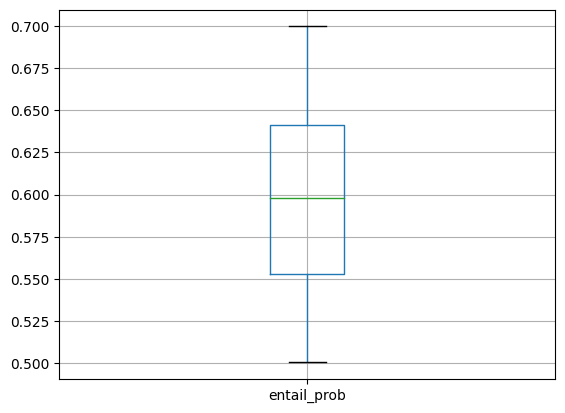

In [25]:
sub.boxplot("entail_prob")

In [26]:
sub = new_df[(new_df.entail_prob > 0.55) & (new_df.entail_prob < 0.7)]
sub.shape

(106, 3)

In [23]:
i = 11
sub = new_df[(new_df.entail_prob > 0.5) & (new_df.entail_prob < 0.7)]
sub.iloc[i].text, sub.iloc[i].label, sub.iloc[i].entail_prob

('Organised just after Radical deputy Facundo Manes had criticised Mauricio Macri, receiving a cataract of reproaches in return, Mauricio Macri invited to dinner Corrientes Province Governor Gustavo Valdés along with the deputies Rodrigo de Loredo, Martín Tetaz, Juan Manuel López and Paula Oliveto (the former two Radical and the latter pair CC-ARI).',
 '<triplet> Radical deputy Facundo Manes <subj> Mauricio Macri <obj> Disapprove',
 0.676742672920227)

In [31]:
for row in sub.iterrows():
    print(row[1].text)
    print(row[1].label)
    print(row[1].entail_prob)
    print("------")

Mr Davis, who was wrongly jailed in Louisiana, says that removing the slavery exemption will strip away an "incentive" for Mr Davis's home state to incarcerate Louisiana's citizens.
<triplet> Mr Davis's home state <subj> Louisiana's citizens <obj> Coerce
0.6285765767097473
------
China have suggested to the Saudis that China price and charge for the oil China sell the Saudis in renminbi.
<triplet> China <subj> the Saudis <obj> Engage In Material Cooperation
0.640461266040802
------
chants on this parking lot in Gera have fallen silent, but Björn Höcke is still biding Björn Höcke's time.
<triplet> Björn Höcke <subj> Björn Höcke's time <obj> Yield
0.5565416216850281
------
Maxim Dlugy said, "Well, world champion Magnus Carlsen just congratulated Maxim Dlugy on being a good mentor, why isn't that good?"
<triplet> world champion Magnus Carlsen <subj> Maxim Dlugy <obj> Engage In Diplomatic Cooperation
0.5538663864135742
------
Mark Finchem, cast Mark Finchem as a defender of the law: Mark F